In [16]:
import os
import pandas as pd
import xarray as xr

def load_classified_reforecast(
    date: str,
    reforecast_dir: str,
    tornado_csv: str
) -> xr.Dataset:
    """
    Load a GEFS reforecast for a given date, subset to Dixie Alley, 
    assign a tornado‐activity class, and drop unused variables.

    Parameters
    ----------
    date : str
        Date string in 'YYYY-MM-DD' format.
    reforecast_dir : str
        Directory containing files named 'YYYYMMDDHHMM_daily_preproc_ml.nc'.
    tornado_csv : str
        Path to CSV of tornado reports with columns 'slat','slon','mag','date'.

    Returns
    -------
    xr.Dataset
        The dataset for the specified date, restricted to 30–36°N, 93–80°W,
        with an integer variable 'class' (0=no tornado, 1=weak, 2=strong)
        and with unneeded variables dropped.
    """
    # build filepath and open dataset
    date_rfm = date.replace('-', '')
    filepath = os.path.join(reforecast_dir, f"{date_rfm}1200_daily_preproc_ml.nc")
    ds = xr.open_dataset(filepath)

    # load and filter tornado data to Dixie Alley
    tor_df = pd.read_csv(tornado_csv)
    tor_dixie = tor_df[
        (tor_df['slat'] >= 30) & (tor_df['slat'] <= 36) &
        (tor_df['slon'] >= -93) & (tor_df['slon'] <= -80)
    ]
    # separate strong vs. weak days
    sigtor = tor_dixie[tor_dixie['mag'] >= 2]
    tor_day = tor_dixie[(tor_dixie['mag'] >= 0) & (tor_dixie['mag'] < 2)]

    # subset dataset to Dixie Alley region
    ds = ds.where(
        (ds.lat >= 30) & (ds.lat <= 36) &
        (ds.lon >= -93) & (ds.lon <= -80),
        drop=True
    )

    # assign class label based on tornado observations
    if date in sigtor['date'].values:
        ds['class'] = 2
    elif date in tor_day['date'].values:
        ds['class'] = 1
    else:
        ds['class'] = 0

    # drop unused variables
    ds = ds.drop_vars([
        'prec', 'ship', 'z500', 'lapse57',
        'mucape', 'frzlvl', 'ulcape', 'mlcape'
    ])

    return ds
ds = load_classified_reforecast(
    date='2011-04-27',
    reforecast_dir='/home/scratch/ahaberlie1/gefs_reforecast_preproc/',
    tornado_csv='/home/z1995995/data_science_for_the_geosciences/495/1950-2023_actual_tornadoes.csv'
)

# Inspect the result
print(ds)


<xarray.Dataset> Size: 6MB
Dimensions:     (init: 5, ens: 11, time: 4, lat: 13, lon: 27)
Coordinates:
  * time        (time) datetime64[ns] 32B 2011-04-27T12:00:00 ... 2011-04-28T...
  * lat         (lat) float32 52B 36.0 35.5 35.0 34.5 ... 31.5 31.0 30.5 30.0
  * lon         (lon) float32 108B -93.0 -92.5 -92.0 -91.5 ... -81.0 -80.5 -80.0
  * init        (init) datetime64[ns] 40B 2011-03-30 2011-04-06 ... 2011-04-27
Dimensions without coordinates: ens
Data variables: (12/19)
    u10         (init, ens, time, lat, lon) float32 309kB 4.875 4.375 ... 2.375
    v10         (init, ens, time, lat, lon) float32 309kB -5.0 -3.875 ... 11.5
    t2m         (init, ens, time, lat, lon) float32 309kB 11.88 12.38 ... 26.0
    td2m        (init, ens, time, lat, lon) float32 309kB 1.5 1.438 ... 21.75
    cprec       (init, ens, time, lat, lon) float32 309kB 0.0 ... 0.01001
    srh500m     (init, ens, time, lat, lon) float32 309kB 18.19 19.69 ... 34.44
    ...          ...
    mslp        (init, ens, 

In [18]:
def assert_20110427_class(
    reforecast_dir: str = '/home/scratch/ahaberlie1/gefs_reforecast_preproc/',
    tornado_csv: str = '/home/z1995995/data_science_for_the_geosciences/495/1950-2023_actual_tornadoes.csv'
):
    """
    Assert that the GEFS reforecast for 2011-04-27 is classified as class 2.
    """
    ds = load_classified_reforecast(
        date='2011-04-27',
        reforecast_dir=reforecast_dir,
        tornado_csv=tornado_csv
    )
    cls = int(ds['class'].item())
    assert cls == 2, f"Expected class 2 for 2011-04-27, got {cls}"
    print("Test passed: 2011-04-27 correctly classified as 2.")

# Run the test
assert_20110427_class()


Test passed: 2011-04-27 correctly classified as 2.


# Domain figure

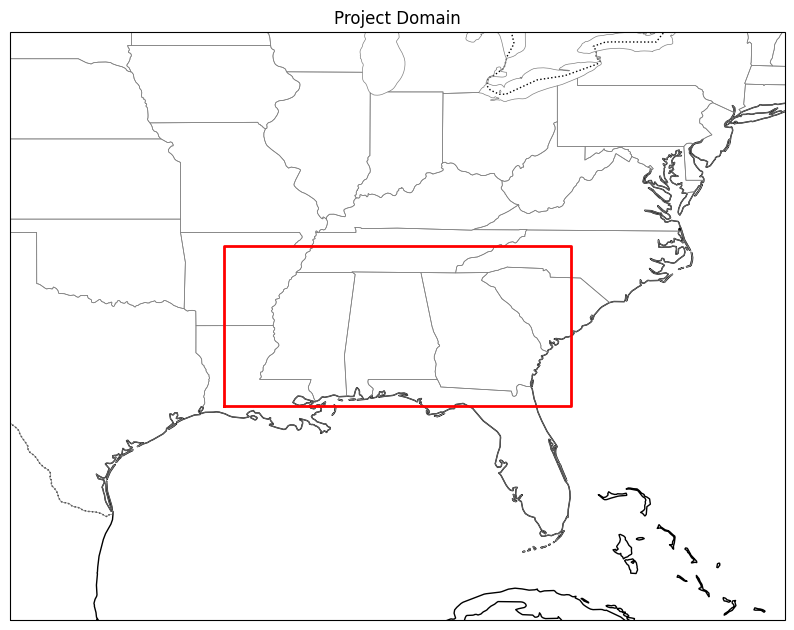

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define your domain bounds
lat_min, lat_max = 30, 36
lon_min, lon_max = -93, -80

# Create the figure and GeoAxes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set an extent slightly larger than your domain for context
buffer = 8
ax.set_extent([lon_min - buffer, lon_max + buffer,
               lat_min - buffer, lat_max + buffer],
              crs=ccrs.PlateCarree())

# Add background features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Draw the domain box
lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
ax.plot(lons, lats, transform=ccrs.PlateCarree(),
        color='red', linewidth=2, label='30°–36°N, 93°–80°W')

# Optional: Add gridlines and a legend
# gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
# gl.top_labels = gl.right_labels = False
# ax.legend(loc='lower left')

plt.title("Project Domain")
plt.savefig('project_domain.png', dpi=300, bbox_inches='tight')
plt.show()
